In [76]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [77]:
device

device(type='cuda')

In [78]:
df = pd.read_csv('/content/diabetes.csv')

In [79]:
df.dropna(inplace = True)

In [80]:
print(len(df))

768


In [81]:
print(df.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [82]:
class DiabetesDataset(Dataset):
  def __init__(self,split = 'Train'):
    super(DiabetesDataset, self).__init__()
    df = pd.read_csv('/content/diabetes.csv').dropna().sample(frac = 1)

    self.df_x = df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']]
    self.df_x[["Glucose", "BloodPressure", "Insulin"]] /= 100
    self.df_x[["BMI", "Age", "SkinThickness", "Pregnancies"]] /= 10
    self.df_y = df[['Outcome']]

    if split == 'Train':
      self.x = torch.from_numpy(self.df_x[0:650].to_numpy()).type(torch.FloatTensor)
      self.y = torch.from_numpy(self.df_y[0:650].to_numpy()).type(torch.LongTensor).squeeze(1)
      self.len = self.x.shape[0]
    elif split == 'Validation':
      self.x = torch.from_numpy(self.df_x[650:710].to_numpy()).type(torch.FloatTensor)
      self.y = torch.from_numpy(self.df_y[650:710].to_numpy()).type(torch.LongTensor).squeeze(1)
      self.len = self.x.shape[0]
    elif split == 'Test':
      self.x = torch.from_numpy(self.df_x[710:].to_numpy()).type(torch.FloatTensor)
      self.y = torch.from_numpy(self.df_y[710:].to_numpy()).type(torch.LongTensor).squeeze(1)
      self.len = self.x.shape[0]

  def __getitem__(self,index):
        return self.x[index],self.y[index]
  def __len__(self):
        return self.len


#call method for split into train,valid and test
train_data = DiabetesDataset(split = 'Train')
valid_data = DiabetesDataset(split = 'Validation')
test_data = DiabetesDataset(split = 'Test')

<ipython-input-82-7dd5752337ce>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_x[["Glucose", "BloodPressure", "Insulin"]] /= 100
<ipython-input-82-7dd5752337ce>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_x[["BMI", "Age", "SkinThickness", "Pregnancies"]] /= 10
<ipython-input-82-7dd5752337ce>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

In [83]:
#batching
train_loader = DataLoader(train_data, batch_size = 16, shuffle = True)
valid_loader = DataLoader(valid_data, batch_size = 10, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 1, shuffle = True)

In [84]:
#Model Creation
class DiabetesNet(nn.Module):
  def __init__(self,input_size,num_classes):
    super(DiabetesNet,self).__init__()
    self.dropout = nn.Dropout(p = 0.05)
    self.input_layer = nn.Sequential(nn.Linear(input_size,50),nn.ReLU()) # there are 50 neurons in first hidden layer that taken inputs from input layer.
    self.h1 = nn.Sequential(nn.Linear(50,100),nn.ReLU())
    self.h2 = nn.Sequential(nn.Linear(100,500),nn.ReLU())
    self.h3 = nn.Sequential(nn.Linear(500, 750), nn.ReLU())
    self.h4 = nn.Sequential(nn.Linear(750, 1000), nn.ReLU())
    self.h5 = nn.Sequential(nn.Linear(1000, 750), nn.ReLU())
    self.h6 = nn.Sequential(nn.Linear(750, 500), nn.ReLU())
    self.h7 = nn.Sequential(nn.Linear(500, 100), nn.ReLU())
    self.h8 = nn.Sequential(nn.Linear(100, 50), nn.ReLU())
    self.h9 = nn.Sequential(nn.Linear(50, num_classes), nn.Softmax(dim = 1))


  def forward(self, x):
    x = self.input_layer(x)
    x = self.h1(x)
    x = self.h2(x)
    x = self.h3(x)
    x = self.h4(x)
    x = self.h5(x)
    x = self.h6(x)
    x = self.h7(x)
    x = self.h8(x)
    x = self.h9(x)
    return x


In [85]:
model = DiabetesNet(8,2) #input_size = 8,num_class = 2 #and our nural network model is ready
learning_rate = 0.0001
epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = learning_rate,weight_decay = 0.000001)
min_loss = np.inf
training_losses,valid_losses,accs = [],[],[]
model.to(device)

DiabetesNet(
  (dropout): Dropout(p=0.05, inplace=False)
  (input_layer): Sequential(
    (0): Linear(in_features=8, out_features=50, bias=True)
    (1): ReLU()
  )
  (h1): Sequential(
    (0): Linear(in_features=50, out_features=100, bias=True)
    (1): ReLU()
  )
  (h2): Sequential(
    (0): Linear(in_features=100, out_features=500, bias=True)
    (1): ReLU()
  )
  (h3): Sequential(
    (0): Linear(in_features=500, out_features=750, bias=True)
    (1): ReLU()
  )
  (h4): Sequential(
    (0): Linear(in_features=750, out_features=1000, bias=True)
    (1): ReLU()
  )
  (h5): Sequential(
    (0): Linear(in_features=1000, out_features=750, bias=True)
    (1): ReLU()
  )
  (h6): Sequential(
    (0): Linear(in_features=750, out_features=500, bias=True)
    (1): ReLU()
  )
  (h7): Sequential(
    (0): Linear(in_features=500, out_features=100, bias=True)
    (1): ReLU()
  )
  (h8): Sequential(
    (0): Linear(in_features=100, out_features=50, bias=True)
    (1): ReLU()
  )
  (h9): Sequential(

In [86]:
def train(min_loss):
    for epoch in range(epochs):
        training_loss = 0
        model.train()
        for x, y in train_loader:
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)
            yhat = model(x) #This is the forward pass of the neural network.
            loss = criterion(yhat, y)
            loss.backward()
            optimizer.step()

            training_loss += loss.item()

        training_losses.append(training_loss)

        valid_loss = 0
        acc = 0
        model.eval()
        with torch.no_grad():
            for x, y in valid_loader:
                x, y = x.to(device), y.to(device)
                yhat = model(x)
                loss = criterion(yhat, y)
                valid_loss += loss.item()

                _, top_class = yhat.topk(1, dim = 1)
                eq = top_class == y.view(-1, 1)
                acc += eq.sum().item()

            valid_losses.append(valid_loss)
            accs.append((acc/len(valid_data)) * 100)

        print("Epoch: {}.. \tTraining Loss: {:.5f}.. \tValid Loss: {:.5f}.. \tAccuracy: {:.2f}%..".format(epoch + 1, training_loss, valid_loss, (acc/len(valid_data)) * 100))

        if valid_loss <= min_loss:
            print("Saving Model {:.4f} ---> {:.4f}".format(min_loss, valid_loss))
            save_obj = OrderedDict([
                ("model", model.state_dict()),
                ("min_loss", min_loss),
                ("learning_rate", learning_rate)
            ])
            torch.save(save_obj,  "diabetes2.pt")
            min_loss = valid_loss


In [87]:
train(min_loss)

Epoch: 1.. 	Training Loss: 27.74931.. 	Valid Loss: 4.06618.. 	Accuracy: 60.00%..
Saving Model inf ---> 4.0662
Epoch: 2.. 	Training Loss: 27.15326.. 	Valid Loss: 4.03900.. 	Accuracy: 60.00%..
Saving Model 4.0662 ---> 4.0390
Epoch: 3.. 	Training Loss: 26.66601.. 	Valid Loss: 3.95186.. 	Accuracy: 60.00%..
Saving Model 4.0390 ---> 3.9519
Epoch: 4.. 	Training Loss: 25.73764.. 	Valid Loss: 4.02423.. 	Accuracy: 60.00%..
Epoch: 5.. 	Training Loss: 24.69252.. 	Valid Loss: 3.66534.. 	Accuracy: 61.67%..
Saving Model 3.9519 ---> 3.6653
Epoch: 6.. 	Training Loss: 23.72297.. 	Valid Loss: 3.52490.. 	Accuracy: 70.00%..
Saving Model 3.6653 ---> 3.5249
Epoch: 7.. 	Training Loss: 23.39784.. 	Valid Loss: 3.64853.. 	Accuracy: 70.00%..
Epoch: 8.. 	Training Loss: 23.71372.. 	Valid Loss: 3.44200.. 	Accuracy: 71.67%..
Saving Model 3.5249 ---> 3.4420
Epoch: 9.. 	Training Loss: 22.33411.. 	Valid Loss: 3.33474.. 	Accuracy: 75.00%..
Saving Model 3.4420 ---> 3.3347
Epoch: 10.. 	Training Loss: 21.99972.. 	Valid Loss

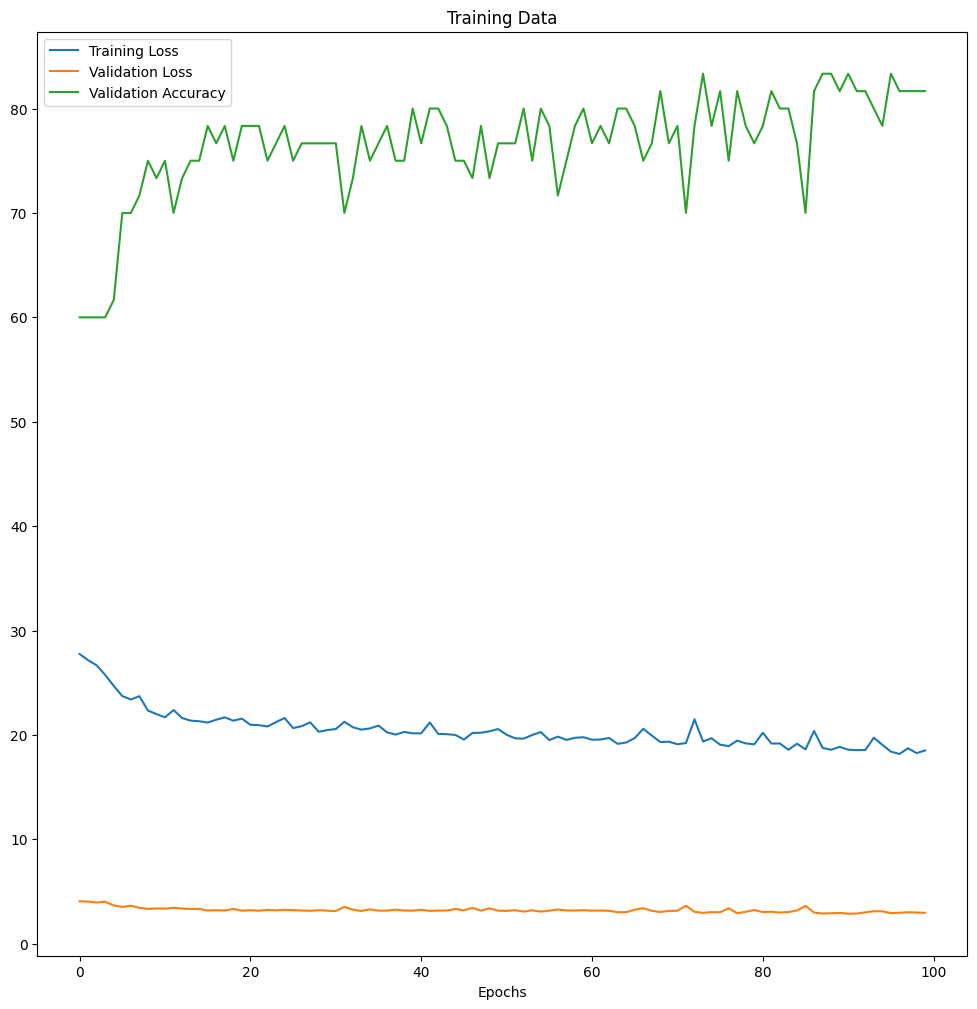

In [88]:
ephs = np.array([i for i in range(epochs)])
plt.figure(figsize = (12,12))
plt.plot(ephs,np.array(training_losses),label = 'Training Loss')
plt.plot(ephs,np.array(valid_losses),label = 'Validation Loss')
plt.plot(ephs,np.array(accs),label = 'Validation Accuracy')
plt.title('Training Data')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [93]:
total_correct = 0
with torch.no_grad():
  model.eval()
  for x,y in test_loader:
    x,y = x.to(device),y.to(device)
    yhat = model(x)
    # Find the top predicted class indices
    top_p,top_class = yhat.topk(1,dim = 1)
    # Check if the predicted classes match the true classes
    # The view(-1, 1) is used to reshape y to have a single column
    eq = top_class == y.view(-1,1)

    #This line sums up the correct predictions across all examples in the batch.
    total_correct += eq.sum().item()

    #The topk(1) operation retrieves only the top 1 predicted value (and its corresponding index) for each example in the batch. It doesn't directly compare all predicted values with the actual values for all classes.

    print("Predicted Value: {}..\tConfidence: {:.4f}%..\tTrue Value: {}..".format(top_class.item(), top_p.item() * 100, y.item()))

print()
print()
print("Score: {}/{}".format(total_correct, len(test_data)))
print("Percentage Correct: {:.2f}%".format((total_correct / len(test_data)) * 100))

Predicted Value: 0..	Confidence: 99.9993%..	True Value: 0..
Predicted Value: 0..	Confidence: 100.0000%..	True Value: 0..
Predicted Value: 0..	Confidence: 100.0000%..	True Value: 0..
Predicted Value: 0..	Confidence: 99.0485%..	True Value: 1..
Predicted Value: 0..	Confidence: 100.0000%..	True Value: 0..
Predicted Value: 0..	Confidence: 100.0000%..	True Value: 0..
Predicted Value: 1..	Confidence: 99.9464%..	True Value: 1..
Predicted Value: 0..	Confidence: 99.9987%..	True Value: 0..
Predicted Value: 0..	Confidence: 100.0000%..	True Value: 0..
Predicted Value: 1..	Confidence: 99.9926%..	True Value: 0..
Predicted Value: 1..	Confidence: 89.0761%..	True Value: 1..
Predicted Value: 0..	Confidence: 99.9984%..	True Value: 0..
Predicted Value: 1..	Confidence: 98.9059%..	True Value: 1..
Predicted Value: 1..	Confidence: 96.5450%..	True Value: 1..
Predicted Value: 0..	Confidence: 95.4433%..	True Value: 0..
Predicted Value: 0..	Confidence: 99.0676%..	True Value: 1..
Predicted Value: 0..	Confidence: 10